# Computer Vision 이상치 탐지 알고리즘 경진대회

## [Public, 0.82654] EfficientNet & crossvalid & weight 정규화

In [48]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob  
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2


import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

device = torch.device('cuda')

In [22]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device, torch.cuda.get_device_name(0))
else :
    device = torch.device('cpu')
    print(device)

cuda NVIDIA GeForce RTX 3080


## load dataset

In [23]:
train_png = sorted(glob('C:/users/IAI/desktop/open/origin_train/*.png'))
test_png = sorted(glob('C:/users/IAI/desktop/open/test/*.png'))
# glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다

In [24]:
len(train_png), len(test_png)

(4277, 2154)

In [25]:
train_y = pd.read_csv('C:/users/IAI/desktop/open/train_df.csv')

train_labels = train_y['label']

label_unique = sorted(np.unique(train_labels)) # train_labels 고유값 정렬

label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}
train_labels = [label_unique[k] for k in train_labels]

## 가중치 정규화

In [26]:
normalize = train_y['label'].value_counts(normalize = True)
# 각 value 별로 비율을 확인하려면 normalize = True 를 사용

In [27]:
weight_ratio = 10 - normalize * 100

In [60]:
weight_list_all = np.ones(88)
for key in weight_ratio.index:
    idx = label_unique[key]
    weight = weight_ratio[key]
    weight_list_all[idx] = weight 
weight_list_all_tensor = torch.FloatTensor(weight_list_all).cuda()
print(weight_list_all_tensor)

tensor([9.7662, 9.7428, 9.7428, 5.1134, 9.8363, 9.8597, 9.8597, 9.8363, 9.8831,
        4.7627, 9.8597, 9.8831, 9.8831, 9.7194, 9.7428, 4.8796, 9.7428, 9.7194,
        9.7662, 9.7662, 9.7896, 3.4534, 9.7896, 9.7896, 9.7662, 9.8597, 9.8597,
        9.8597, 3.8274, 9.8597, 9.8597, 9.7896, 9.7896, 0.8581, 9.7896, 9.7896,
        9.7662, 9.7662, 9.7896, 9.7662, 4.2717, 9.7896, 9.6960, 9.7428, 9.7194,
        4.8562, 9.7194, 9.6960, 9.7896, 9.7428, 9.6960, 9.7662, 3.7573, 9.8831,
        9.7194, 2.5181, 9.7194, 9.7194, 9.6960, 9.7194, 9.7194, 9.7896, 9.7896,
        4.6224, 9.8130, 9.7896, 9.8130, 9.6493, 8.5971, 9.8831, 9.8831, 9.8831,
        5.0199, 9.8831, 9.9065, 9.8597, 4.2249, 9.8831, 9.8831, 9.7428, 9.7662,
        9.8130, 9.7896, 9.8130, 4.3886, 9.7896, 9.7896, 9.8130],
       device='cuda:0')


In [61]:
# https://leechamin.tistory.com/240
# cv2.imread() , cv2.imshow(), cv2.imwrite()
# read image : cv2.imread(filename, flag)
# flag : 어떤 방식으로 이미지를 읽을 것인가
# 대표적인 방법들은 다음과 같다/.
# cv2.Imread_color(1), Grayscale(0), Unchanged(-1)
# imshow('windowname', img)
# cv2.imwrite(filename, img)


# a =cv2.imread(train_png[0])

# import numpy as np
# from PIL import Image
# pil_image=Image.fromarray(a)
# pil_image.show()

# b =cv2.imread(train_png[0])[:,:,::-1]

# import numpy as np
# from PIL import Image
# pil_image=Image.fromarray(b)
# pil_image.show()

In [62]:
# OpecCV를 사용해서 사진을 matplotlib으로 화면에 출력하는 방법
# 컬러 사진을 OpenCV에서는 BGR 순서로 저장하는데 matplotlib에서는 RGB 순서로 저장합니다.[:,:,::-1] -> 열의 순서만 뒤집는다.
# ex) [1,2,3] BGR--> [3,2,1] RGB
# 따라서 BGR -> RGB 로 바꾸어 주어야 합니다.

# 그림BGR = cv2.imread("그림파일.jpg")
# 그림RGB = cv2.cvtColor(그림BGR, cv2.COLOR_BGR2RGB)
# 출처: https://crmn.tistory.com/49 [크롬망간이 글 쓰는 공간:티스토리]

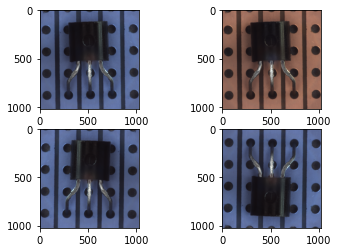

In [63]:
fig = plt.figure()
rows = 2
cols = 2

img1 = cv2.imread(train_png[0])

ax1 = fig.add_subplot(rows,cols,1)
#ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.imshow(img1) #bgr 그대로

img2 = cv2.imread(train_png[0])[:,:,::-1]
ax2 = fig.add_subplot(rows,cols,2)
ax2.imshow(img2) # rgb : 열만 순서 뒤집음

img3 = cv2.imread(train_png[0])[:,::-1]
ax3 = fig.add_subplot(rows,cols,3)
ax3.imshow(img3) # 행 순서 뒤집음  :좌우 반전

img4 = cv2.imread(train_png[0])[::-1]
ax4 = fig.add_subplot(rows,cols,4)
ax4.imshow(img4) # 1d 순서 뒤집음. : 위아래반전


plt.show()

In [64]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (384,384), interpolation = cv2.INTER_AREA)
    return img

In [65]:
# cv2.resize(img, (384,384), interpolation = cv2.INTER_AREA)
# cv2.interarea : 영상 축소 시 효과적
# https://deep-learning-study.tistory.com/185

In [67]:
train_imgs = np.load('train_imgs_384.npy')
test_imgs = np.load('test_imgs_384.npy')

# modeling

In [87]:
import torch.cuda.amp as amp
# 파이토치에서 amp를 쓴다는 것은 학습할 때
# torch.cuda.amp.autooast와 torch.cuda.amp.GradScaler를 같이 쓴다는 의미.

# mixed precision이란 , torch에서 몇가지 연산은 torch.float32 타입을 쓰고 어떤 연산은 torch.float16을 쓴다.

In [80]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode = 'train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode == 'train':
            train_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.433038, 0.403458, 0.394151],
                                    std = [0.181572,0.174035, 0.163234]),
                transforms.RandomAffine((-45, 45)),
            ])
            img = train_transform(img)
            
        if self.mode == 'test':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.418256, 0.393101, 0.386632],
                                     std = [0.195055, 0.190053, 0.185323])
            ])
            img = test_transform(img)
            
        label = self.labels[idx]
        return img, label

class Network(nn.Module):
    def __init__(self, mode = 'train'):
        super(Network, self).__init__()
        self.mode =mode
        if self.mode == 'train':
            self.model = timm.create_model('efficientnet_b4', pretrained=True, num_classes =88, drop_path_rate = 0.2)
        if self.mode == 'test':
            self.model = timm.create_model('efficientnet_b4', pretrained=True, num_classes =88, drop_path_rate = 0)
            
    def forward(self, x):
        x = self.model(x)
        return x

In [81]:
def score_function(real, pred):
    score = f1_score(real, pred, average='macro')
    return score

In [86]:
import gc

gc.collect()
torch.cuda.empty_cache()

cv = StratifiedKFold(n_splits= 5, random_state=2022, shuffle=True)
batch_size = 16
epochs = 200
pred_ensemble = []

for idx, (train_idx, val_idx) in enumerate(cv.split(train_imgs, np.array(train_labels))):
    print('======================fold_{} start================='.format(idx))
    t_imgs, val_imgs = train_imgs[train_idx], train_imgs[val_idx]
    t_labels, val_labels = np.array(train_labels)[train_idx], np.array(train_labels)[val_idx]
    
    #train
    
    train_dataset = Custom_dataset(np.array(t_imgs), np.array(t_labels), mode = 'train')
    train_loader = DataLoader(train_dataset, shuffle= True , batch_size = batch_size)
    
    # val
    val_dataset = Custom_dataset(np.array(val_imgs), np.array(val_labels), mode = 'test')
    val_loader = DataLoader(val_dataset, shuffle=True, batch_size= batch_size)
    
    gc.collect()
    torch.cuda.empty_cache()
    best = 0
    
    model = Network().to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr= 2e-4,weight_decay = 2e-2)
    criterion = nn.CrossEntropyLoss(weight= weight_list_all_tensor)
    scaler = torch.cuda.amp.GradScaler()
    
    best_f1 = 0
    early_stopping = 0
    for epoch in range(epochs):
        start = time.time()
        train_loss =0
        train_pred = []
        train_y = []
        model.train()
        
        for batch in (train_loader):
            optimizer.zero_grad()
            x = torch.tensor(batch[0], dtype=torch.float32, device=device)
            y = torch.tensor(batch[1], dtype= torch.long, device=device)
            with torch.cuda.amp.autocast():
                pred= model(x)
            loss = criterion(pred.float(), y)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()/ len(train_loader)
            train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
            train_y += y.detach().cpu().numpy().tolist()
        train_f1 =score_function(train_y, train_pred)
        state_dict = model.state_dict()
        model.eval()
        with torch.no_grad():
            val_loss =0
            val_pred = []
            val_y = []
            
            for batch in (val_loader):
                x_val = torch.tensor(batch[0], dtype=torch.float32, device =device)
                y_val = torch.tensor(batch[1], dtype=torch.long, device=device)
                with torch.cuda.amp.autocast():
                    pred_val = model(x_val)
                loss_val = criterion(pred_val.float(), y_val)
                
                val_loss += loss_val.item()/len(val_loader)
                val_pred += pred_val.argmax(1).detach().cpu().numpy().tolist()
                val_y += y_val.detach().cpu().numpy().tolist()
                
            val_f1 = score_function(val_y, val_pred)
            
            if val_f1 > best_f1:
                best_epoch = epoch
                best_loss = val_loss
                best_f1 = val_f1
                early_stopping = 0
                
                torch.save({'epoch': epoch,
                           'state_dict':state_dict,
                           'optimizer':optimizer.state_dict(),
                           'scaler':scaler.state_dict(),
                           }, 'best_model_2{}.pth'.format(idx))
                print('-------------------save:{}epoch------------'.format(best_epoch+1))
            else :
                early_stopping += 1
                
            if early_stopping == 10:
                TIME = time.time() - start
                print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
                print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
                print(f'Val    loss : {val_loss:.5f}    f1 : {val_f1:.5f}')
                print('-------early_stop-------')
                break     
            
            
            TIME = time.time() - start
            print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
            print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
            print(f'Val    loss : {val_loss:.5f}    f1 : {val_f1:.5f}')
        
        
    
    


======================fold_0 start=================
-------------------save:1epoch------------
epoch : 1/200    time : 95s/18842s
TRAIN    loss : 1.93701    f1 : 0.17051
Val    loss : 1.07355    f1 : 0.24208
-------------------save:2epoch------------
epoch : 2/200    time : 92s/18175s
TRAIN    loss : 0.94162    f1 : 0.35702
Val    loss : 0.78943    f1 : 0.38792
-------------------save:3epoch------------
epoch : 3/200    time : 90s/17793s
TRAIN    loss : 0.69438    f1 : 0.49019
Val    loss : 0.62084    f1 : 0.49665
-------------------save:4epoch------------
epoch : 4/200    time : 90s/17643s
TRAIN    loss : 0.54046    f1 : 0.60670
Val    loss : 0.48354    f1 : 0.60052
-------------------save:5epoch------------
epoch : 5/200    time : 92s/17965s
TRAIN    loss : 0.41893    f1 : 0.67778
Val    loss : 0.46412    f1 : 0.60993
-------------------save:6epoch------------
epoch : 6/200    time : 92s/17882s
TRAIN    loss : 0.34970    f1 : 0.74055
Val    loss : 0.33671    f1 : 0.69862
epoch : 7/20

epoch : 9/200    time : 90s/17097s
TRAIN    loss : 0.17528    f1 : 0.87385
Val    loss : 0.36964    f1 : 0.70831
-------------------save:10epoch------------
epoch : 10/200    time : 90s/17097s
TRAIN    loss : 0.14321    f1 : 0.90337
Val    loss : 0.24437    f1 : 0.80750
epoch : 11/200    time : 90s/16950s
TRAIN    loss : 0.12752    f1 : 0.90291
Val    loss : 0.29587    f1 : 0.75679
-------------------save:12epoch------------
epoch : 12/200    time : 90s/16920s
TRAIN    loss : 0.10220    f1 : 0.93107
Val    loss : 0.25844    f1 : 0.82686
epoch : 13/200    time : 90s/16772s
TRAIN    loss : 0.08567    f1 : 0.92415
Val    loss : 0.32120    f1 : 0.80285
epoch : 14/200    time : 90s/16667s
TRAIN    loss : 0.09031    f1 : 0.92921
Val    loss : 0.32836    f1 : 0.79537
epoch : 15/200    time : 89s/16551s
TRAIN    loss : 0.07088    f1 : 0.94372
Val    loss : 0.30589    f1 : 0.79935
epoch : 16/200    time : 90s/16504s
TRAIN    loss : 0.06377    f1 : 0.95335
Val    loss : 0.33183    f1 : 0.79073
e

epoch : 14/200    time : 91s/16834s
TRAIN    loss : 0.09852    f1 : 0.92892
Val    loss : 0.29689    f1 : 0.79935
-------------------save:15epoch------------
epoch : 15/200    time : 91s/16820s
TRAIN    loss : 0.08608    f1 : 0.93157
Val    loss : 0.26519    f1 : 0.80904
-------------------save:16epoch------------
epoch : 16/200    time : 91s/16695s
TRAIN    loss : 0.06441    f1 : 0.95997
Val    loss : 0.24350    f1 : 0.81628
-------------------save:17epoch------------
epoch : 17/200    time : 91s/16625s
TRAIN    loss : 0.05342    f1 : 0.96392
Val    loss : 0.29538    f1 : 0.83163
epoch : 18/200    time : 91s/16502s
TRAIN    loss : 0.06954    f1 : 0.95473
Val    loss : 0.26186    f1 : 0.81579
-------------------save:19epoch------------
epoch : 19/200    time : 92s/16701s
TRAIN    loss : 0.07720    f1 : 0.95019
Val    loss : 0.24952    f1 : 0.83389
epoch : 20/200    time : 91s/16433s
TRAIN    loss : 0.04778    f1 : 0.97244
Val    loss : 0.31362    f1 : 0.80953
-------------------save:21

In [88]:
pred_ensemble = []
batch_size = 32

test_dataset = Custom_dataset(np.array(test_imgs), np.array(['tmp']* len(test_imgs)), mode = 'test')
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = batch_size)

for i in range(5):
    model_test = Network(mode='test').to(device)
    model_test.load_state_dict(torch.load(('best_model_2{}.pth'.format(i)))['state_dict'])
    model_test.eval()
    pred_prob = []
    with torch.no_grad():
        for batch in (test_loader):
            x = torch.tensor(batch[0], dtype=torch.float32, device = device)
            with torch.cuda.amp.autocast():
                pred = model_test(x)
                pred_prob.extend(pred.detach().cpu().numpy())
        pred_ensemble.append(pred_prob)

In [89]:
len(pred_ensemble)

5

In [95]:
pred = (np.array(pred_ensemble[1])+ np.array(pred_ensemble[3]) + np.array(pred_ensemble[4]) ) / 3 
f_pred = np.array(pred).argmax(1).tolist()

In [96]:
label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

In [99]:
submission = pd.read_csv('C:/users/IAI/desktop/open/sample_submission.csv')
              
submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-good
3,3,tile-gray_stroke
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good


In [21]:
submission.to_csv('submission.csv', index = False)

In [22]:
submission = pd.read_csv("./desktop/open/sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-thread
2,2,cable-missing_cable
3,3,tile-crack
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-combined


In [100]:
submission.to_csv('submission_try1.csv', index = False)